## Importing libs and loading the dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# obs.: Notebook shortcuts: https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/
#       pandas' Cheat Sheet: https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf

In [2]:
%matplotlib inline
sns.set() # switch plotted figures aesthetics (look) from matplotlib to seaborn defaults

In [3]:
dataset_csv_path = "Metro_Interstate_Traffic_Volume.csv" # 8 attributes of 48,204 examples

# loading the dataset with pandas (instead of numpy or csv) since there are different datatypes
dataset_csv = pd.read_csv(dataset_csv_path, delimiter=',')
dataset_csv.dtypes

holiday                 object
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all               int64
weather_main            object
weather_description     object
date_time               object
traffic_volume           int64
dtype: object

## Dataset attributes
1: **holiday**: US National holidays plus regional holiday, Minnesota State Fair\
2: **temp**: average temp in kelvin\
3: **rain 1h**: amount in mm of rain that occurred in the hour\
4: **snow 1h**: amount in mm of snow that occurred in the hour\
5: **clouds all**: percentage of cloud cover\
6: **weather main**: short textual description of the current weather\
7: **weather description**: longer textual description of the current weather\
8: **date time**: hour of the data collected in local CST time\
target: **traffic volume**: traffic volume

In [9]:
dataset_csv.head(n=10) # peeks into the resulting pandas.DataFrame

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
5,None,291.72,0.0,0.0,1,Clear,sky is clear,2012-10-02 14:00:00,5181
6,None,293.17,0.0,0.0,1,Clear,sky is clear,2012-10-02 15:00:00,5584
7,None,293.86,0.0,0.0,1,Clear,sky is clear,2012-10-02 16:00:00,6015
8,None,294.14,0.0,0.0,20,Clouds,few clouds,2012-10-02 17:00:00,5791
9,None,293.10,0.0,0.0,20,Clouds,few clouds,2012-10-02 18:00:00,4770


## Visualizing the data

In [13]:
# obs.: the two following notations are valid, and both return a pandas.Series object
#dataset_csv.date_time
dataset_csv["date_time"]

0        2012-10-02 09:00:00
1        2012-10-02 10:00:00
2        2012-10-02 11:00:00
3        2012-10-02 12:00:00
4        2012-10-02 13:00:00
                ...         
48199    2018-09-30 19:00:00
48200    2018-09-30 20:00:00
48201    2018-09-30 21:00:00
48202    2018-09-30 22:00:00
48203    2018-09-30 23:00:00
Name: date_time, Length: 48204, dtype: object

In [4]:
from datetime import datetime
def date_time_dif(str1, str2):
    str_format = "%Y-%m-%d %H:%M:%S"
    dt1 = datetime.strptime(str1, str_format)
    dt2 = datetime.strptime(str2, str_format)
    return (dt1 - dt2)

time_span = date_time_dif(dataset_csv.date_time.iloc[-1], dataset_csv.date_time.iloc[0])

print(dataset_csv["date_time"])
print("\nTime span: " + str(time_span))

0        2012-10-02 09:00:00
1        2012-10-02 10:00:00
2        2012-10-02 11:00:00
3        2012-10-02 12:00:00
4        2012-10-02 13:00:00
                ...         
48199    2018-09-30 19:00:00
48200    2018-09-30 20:00:00
48201    2018-09-30 21:00:00
48202    2018-09-30 22:00:00
48203    2018-09-30 23:00:00
Name: date_time, Length: 48204, dtype: object

Time span: 2189 days, 14:00:00


In [5]:
traffic_volume = dataset_csv["traffic_volume"]
min_vol = traffic_volume.min()
max_vol = traffic_volume.max()
print(f"min: {min_vol}, max: {max_vol}, mean: {traffic_volume.mean():.2f}")

min: 0, max: 7280, mean: 3259.82


In [6]:
dataset_csv.query(f"traffic_volume == {min_vol}") # obs.: same as dataset_csv[dataset_csv["traffic_volume"] == min_vol]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
25186,None,296.68,0.0,0.0,40,Rain,light rain,2016-07-23 18:00:00,0
25191,None,295.90,0.0,0.0,90,Haze,haze,2016-07-23 23:00:00,0


In [9]:
# see values around the entries of min traffic volume
display_columns = dataset_csv.columns[~dataset_csv.columns.isin(["holiday", "clouds_all", "weather_description"])]
dataset_csv.iloc[25186 - 3 : 25191 + 4][display_columns].reset_index() # obs.: the original index is in the "index" column

,index,temp,rain_1h,snow_1h,weather_main,date_time,traffic_volume
0,25183,295.22,10.67,0.0,Mist,2016-07-23 16:00:00,7
1,25184,295.54,0.51,0.0,Rain,2016-07-23 17:00:00,5
2,25185,295.54,0.51,0.0,Mist,2016-07-23 17:00:00,5
3,25186,296.68,0.00,0.0,Rain,2016-07-23 18:00:00,0
4,25187,297.48,0.00,0.0,Clouds,2016-07-23 19:00:00,1
5,25188,297.21,0.00,0.0,Clouds,2016-07-23 20:00:00,5
6,25189,296.47,0.00,0.0,Clouds,2016-07-23 21:00:00,2
7,25190,295.96,0.00,0.0,Clouds,2016-07-23 22:00:00,1
8,25191,295.90,0.00,0.0,Haze,2016-07-23 23:00:00,0
9,25192,295.96,0.00,0.0,Clouds,2016-07-24 00:00:00,6


In [8]:
mean_values = dataset_csv.groupby("weather_main")[["temp", "traffic_volume"]].mean()
mean_values["temp_celsius"] = mean_values["temp"].apply(lambda temp_K: temp_K - 273.15)
mean_values["size"] = dataset_csv.groupby("weather_main").size() # amount of entries in each group

# order by the weather conditions which have the largest mean traffic volume
mean_values.sort_values(by="traffic_volume", ascending=False)

,temp,traffic_volume,temp_celsius,size
weather_main,,,,
Clouds,281.466101,3618.449749,8.316101,15164
Haze,275.818581,3502.101471,2.668581,1360
Rain,286.979586,3317.905501,13.829586,5672
Drizzle,283.795431,3290.727073,10.645431,1821
Smoke,290.927500,3237.650000,17.777500,20
Clear,281.489971,3055.908819,8.339971,13391
Snow,267.955188,3016.844228,-5.194812,2876
Thunderstorm,292.716431,3001.620890,19.566431,1034
Mist,279.476892,2932.956639,6.326892,5950


## Visualizing the data with [seaborn](https://seaborn.pydata.org/)

In [6]:
# attributes:
# - "holiday",              object
# - "temp",                float64
# - "rain_1h",             float64
# - "snow_1h",             float64
# - "clouds_all",            int64
# - "weather_main",         object
# - "weather_description",  object
# - "date_time",            object

# target:
# - "traffic_volume",        int64

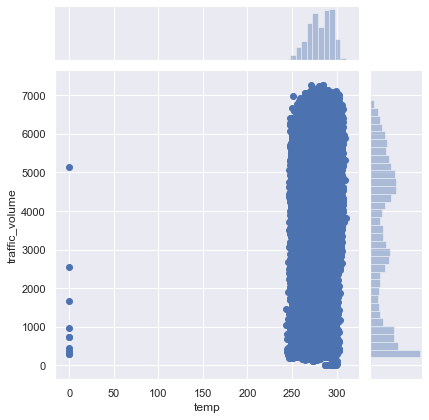

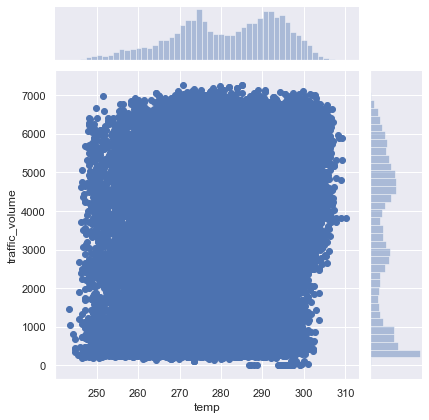

In [16]:
# NOTE: some entries have an invalid temp value of 0 Kelvin
sns.jointplot(x="temp", y="traffic_volume", data=dataset_csv)
sns.jointplot(x="temp", y="traffic_volume", data=dataset_csv[dataset_csv.temp > 0.0])

## Data cleaning

In [16]:
# NOTE: the holiday field is only annotated on the 0th hour of the day
dataset_csv[dataset_csv.holiday != "None"].head(n=10)[["holiday", "date_time", "traffic_volume"]]

,holiday,date_time,traffic_volume
126,Columbus Day,2012-10-08 00:00:00,455
1123,Veterans Day,2012-11-12 00:00:00,1000
1370,Thanksgiving Day,2012-11-22 00:00:00,919
2360,Christmas Day,2012-12-25 00:00:00,803
2559,New Years Day,2013-01-01 00:00:00,1439
3697,Washingtons Birthday,2013-02-18 00:00:00,556
6430,Memorial Day,2013-05-27 00:00:00,863
7414,Independence Day,2013-07-04 00:00:00,1060
8575,State Fair,2013-08-22 00:00:00,661
8742,Labor Day,2013-09-02 00:00:00,1041


## 1. $(0.25 pts)$ Split the data for providing your results and avoid overfitting.
Keep in mind that friends don’t let friends use testing data for training :-).

## 2. $(3 pts)$ Perform Linear Regression.
**You should implement your solution** and compare it with [sklearn.linear model.SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) (“linear model fitted by minimizing a regularized empirical loss with [SGD](https://scikit-learn.org/stable/modules/sgd.html)”). What are the conclusions?

## 3. $(0.75 pts)$ Plot the cost function $vs.$ number of iterations in the training set and analyze the model complexity.
What are the conclusions? What are the actions after such analyses?

## 4. $(1 pts)$ Use different Gradient Descent (GD) learning rates when optimizing. Compare the GD-based solutions with Normal Equation.
**You should implement your solutions**. What are the conclusions?

## 5. $(4 pts)$ Prepare a 4-page (max.) report with all your findings.
It is UP TO YOU to convince the reader that you are proficient on linear regression and the choices it entails.

## 6. $(1 pts)$ You should provide a single Jupyter notebook with your solution (in Python 3 code).